HDBSCAN → K‑Medoids → GMM

In [4]:
!pip install scikit-learn-extra
import warnings
warnings.filterwarnings("ignore")



  Using cached scikit-learn-extra-0.3.0.tar.gz (818 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build scikit-learn-extra


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [73 lines of output]
  C:\Users\srira\AppData\Local\Temp\pip-build-env-9vsbgs3u\overlay\Lib\site-packages\setuptools\dist.py:589: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
  
          This deprecation is overdue, please update your project and remove deprecated
          calls to avoid build errors in the future.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    opt = self.warn_dash_deprecation(opt, section)
  C:\Users\srira\AppData\Local\Temp\pip-build-env-9vsbgs3u\overlay\Lib\site-packages\setup

Pipeline 1 (HDBSCAN → K-Medoids → GMM)
Best silhouette score: 0.7562929739565915
Best HDBSCAN params: {'min_samples': 9, 'min_cluster_size': 15}


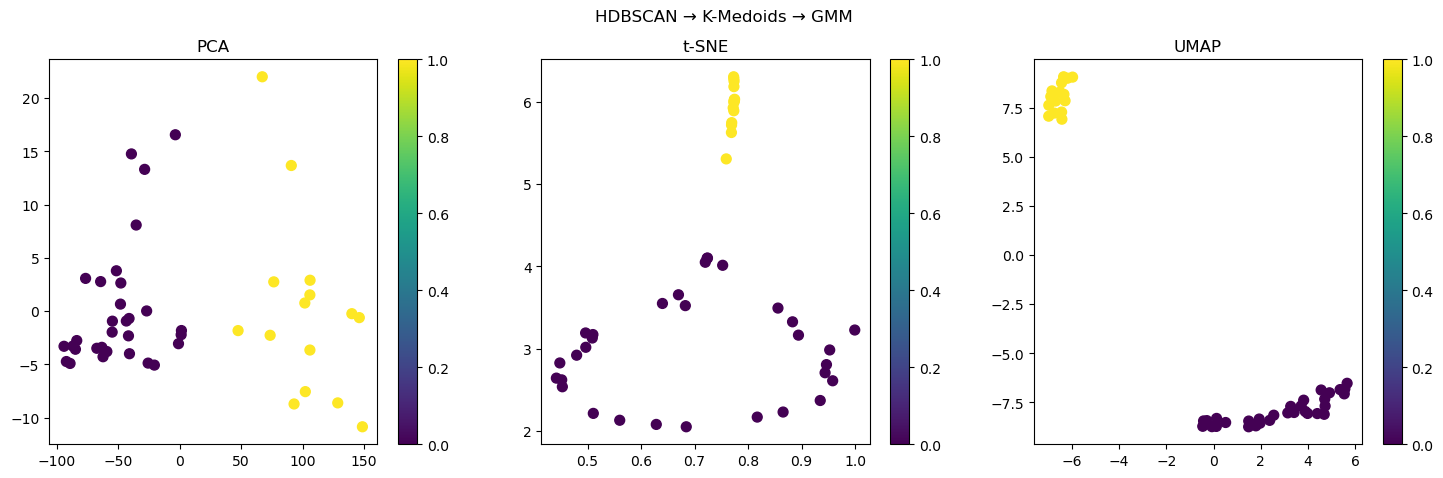

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation and hyperparameter tuning
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler

# Clustering algorithms
import hdbscan
from sklearn.mixture import GaussianMixture

# For alternative K-Medoids using pyclustering
from pyclustering.cluster.kmedoids import kmedoids
import random

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# -------------------------------
# Load CSV file and preprocess data
# -------------------------------
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv" # Update to your CSV file path
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# -------------------------------
# Alternative K-Medoids using pyclustering
# -------------------------------
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    """
    Runs K-Medoids using pyclustering.
    
    Parameters:
      X          : numpy array of shape (n_samples, n_features)
      n_clusters : desired number of clusters
      random_state: seed for reproducibility
      
    Returns:
      labels      : numpy array of cluster labels for X
      medoid_coords: numpy array of medoid coordinates used for initialization
    """
    # Convert data to list of lists for pyclustering
    data_list = X.tolist()
    n_samples = len(data_list)
    
    # Choose initial medoid indices randomly
    initial_medoids = random.sample(range(n_samples), n_clusters)
    
    # Run K-Medoids from pyclustering
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()   # list of clusters (each is list of indices)
    final_medoids = kmedoids_instance.get_medoids() # final medoid indices
    
    # Create label array (initialize with -1)
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
            
    # Compute medoid coordinates using final medoid indices
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# -------------------------------
# Visualization Function
# -------------------------------
def visualize_clusters(X, labels, title="Clusters"):
    # PCA reduction
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    # t-SNE reduction
    tsne = TSNE(n_components=2, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    # UMAP reduction
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    X_umap = reducer.fit_transform(X)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    sc1 = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    axs[0].set_title("PCA")
    plt.colorbar(sc1, ax=axs[0])
    
    sc2 = axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
    axs[1].set_title("t-SNE")
    plt.colorbar(sc2, ax=axs[1])
    
    sc3 = axs[2].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=50)
    axs[2].set_title("UMAP")
    plt.colorbar(sc3, ax=axs[2])
    
    plt.suptitle(title)
    plt.show()

# -------------------------------
# Pipeline 1: HDBSCAN → Alternative K-Medoids → GMM
# -------------------------------
def run_pipeline_hdbscan_kmedoids_gmm(X, n_iter=20):
    best_score = -1
    best_params = None
    best_labels = None  # Tuple: (hdb_labels, kmed_labels, gmm_labels, mask)
    
    # Random search grid for HDBSCAN parameters
    param_grid = {
       'min_cluster_size': list(range(5, 50)),
       'min_samples': list(range(1, 20))
    }
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    
    for params in param_list:
        # Step 1: HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=params['min_cluster_size'],
                                    min_samples=params['min_samples'])
        hdb_labels = clusterer.fit_predict(X)
        # Remove noise (label = -1)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(hdb_labels[mask]))
        if n_clusters < 2:
            continue
        
        # Step 2: Alternative K-Medoids refinement on filtered data
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        
        # Step 3: GMM for probabilistic classification using medoid coordinates as initialization
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue

        # Evaluate clustering using silhouette score
        try:
            score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            score = -1

        if score > best_score:
            best_score = score
            best_params = params
            best_labels = (hdb_labels, kmed_labels, gmm_labels, mask)
            
    print("Pipeline 1 (HDBSCAN → K-Medoids → GMM)")
    print("Best silhouette score:", best_score)
    print("Best HDBSCAN params:", best_params)
    return best_labels, best_score

if __name__ == "__main__":
    labels_pipe1, score1 = run_pipeline_hdbscan_kmedoids_gmm(X)
    if labels_pipe1 is not None:
        # Visualize only non-noise points
        hdb_labels, kmed_labels, gmm_labels, mask = labels_pipe1
        visualize_clusters(X[mask], gmm_labels, title="HDBSCAN → K-Medoids → GMM")


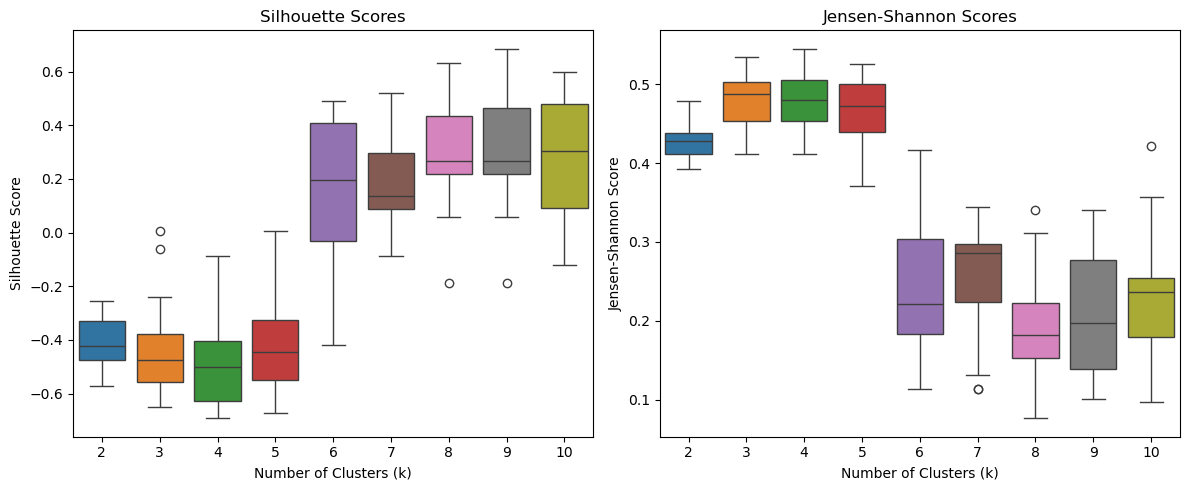

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
import hdbscan
from pyclustering.cluster.kmedoids import kmedoids
import random

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load dataset (replace with actual data)
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# Define clustering stability test
num_runs = 25
k_values = range(2, 11)
silhouette_scores = {k: [] for k in k_values}
jensen_shannon_scores = {k: [] for k in k_values}

def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

for k in k_values:
    for _ in range(num_runs):
        # Step 1: HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=max(1, k // 2))
        hdb_labels = clusterer.fit_predict(X)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(hdb_labels[mask]))
        if n_clusters < 2:
            continue
        
        # Step 2: Alternative K-Medoids
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        
        # Step 3: GMM
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        # Compute silhouette score
        try:
            sil_score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            sil_score = -1
        silhouette_scores[k].append(sil_score)
        
        # Compute Jensen-Shannon score
        cluster_probs = gmm.predict_proba(X_filtered).mean(axis=0)
        uniform_dist = np.ones(n_clusters) / n_clusters
        js_score = jensenshannon(cluster_probs, uniform_dist)
        jensen_shannon_scores[k].append(js_score)

# Convert results into boxplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot for silhouette scores
sns.boxplot(data=[silhouette_scores[k] for k in k_values], ax=axs[0])
axs[0].set_xticklabels(k_values)
axs[0].set_title("Silhouette Scores")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Silhouette Score")

# Boxplot for Jensen-Shannon scores
sns.boxplot(data=[jensen_shannon_scores[k] for k in k_values], ax=axs[1])
axs[1].set_xticklabels(k_values)
axs[1].set_title("Jensen-Shannon Scores")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Jensen-Shannon Score")

plt.tight_layout()
plt.show()


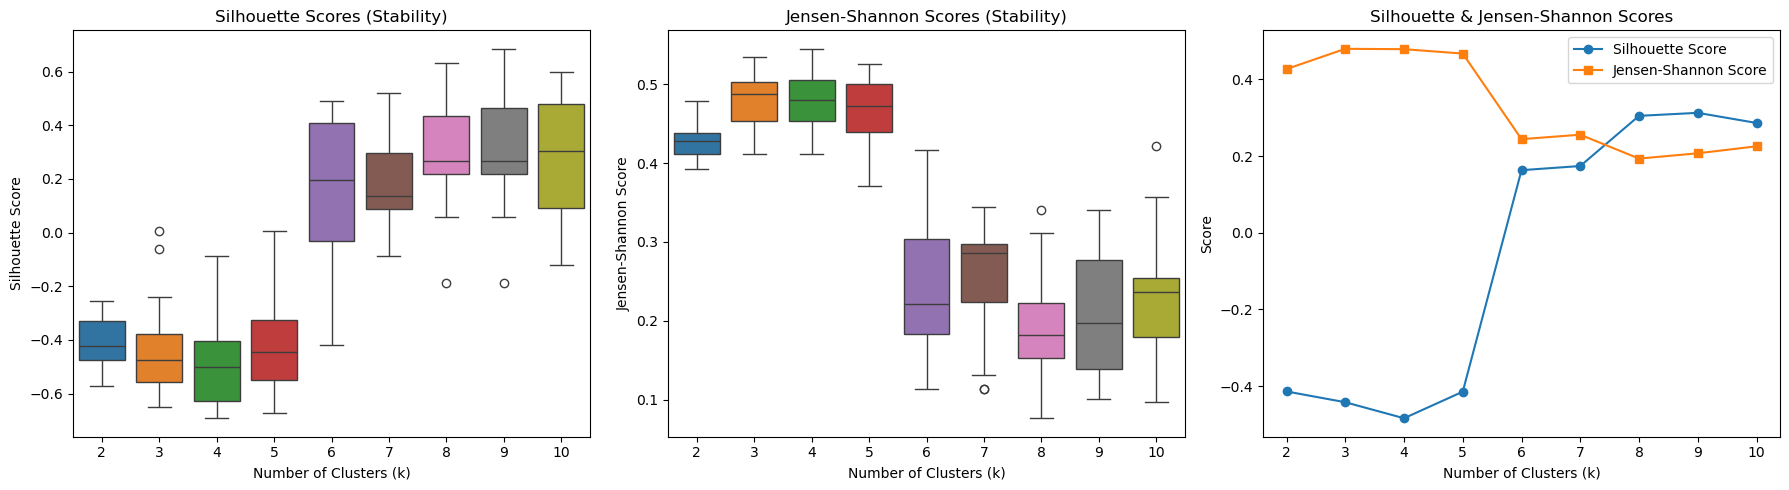

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
import hdbscan
from pyclustering.cluster.kmedoids import kmedoids
import random
import pandas as pd
from sklearn.mixture import GaussianMixture

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load dataset (replace with actual data)
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# Define clustering stability test
num_runs = 25
k_values = range(2, 11)
silhouette_scores = {k: [] for k in k_values}
jensen_shannon_scores = {k: [] for k in k_values}

def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

for k in k_values:
    for _ in range(num_runs):
        # Step 1: HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=max(1, k // 2))
        hdb_labels = clusterer.fit_predict(X)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(hdb_labels[mask]))
        if n_clusters < 2:
            continue
        
        # Step 2: Alternative K-Medoids
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        
        # Step 3: GMM
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        # Compute silhouette score
        try:
            sil_score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            sil_score = -1
        silhouette_scores[k].append(sil_score)
        
        # Compute Jensen-Shannon score
        cluster_probs = gmm.predict_proba(X_filtered).mean(axis=0)
        uniform_dist = np.ones(n_clusters) / n_clusters
        js_score = jensenshannon(cluster_probs, uniform_dist)
        jensen_shannon_scores[k].append(js_score)

# Convert results into boxplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot for silhouette scores
sns.boxplot(data=[silhouette_scores[k] for k in k_values], ax=axs[0])
axs[0].set_xticklabels(k_values)
axs[0].set_title("Silhouette Scores (Stability)")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Silhouette Score")

# Boxplot for Jensen-Shannon scores
sns.boxplot(data=[jensen_shannon_scores[k] for k in k_values], ax=axs[1])
axs[1].set_xticklabels(k_values)
axs[1].set_title("Jensen-Shannon Scores (Stability)")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Jensen-Shannon Score")

# Line plot for silhouette and Jensen-Shannon scores
mean_silhouette = [np.mean(silhouette_scores[k]) for k in k_values]
mean_js = [np.mean(jensen_shannon_scores[k]) for k in k_values]
axs[2].plot(k_values, mean_silhouette, marker='o', label='Silhouette Score')
axs[2].plot(k_values, mean_js, marker='s', label='Jensen-Shannon Score')
axs[2].set_title("Silhouette & Jensen-Shannon Scores")
axs[2].set_xlabel("Number of Clusters (k)")
axs[2].set_ylabel("Score")
axs[2].legend()

plt.tight_layout()
plt.show()


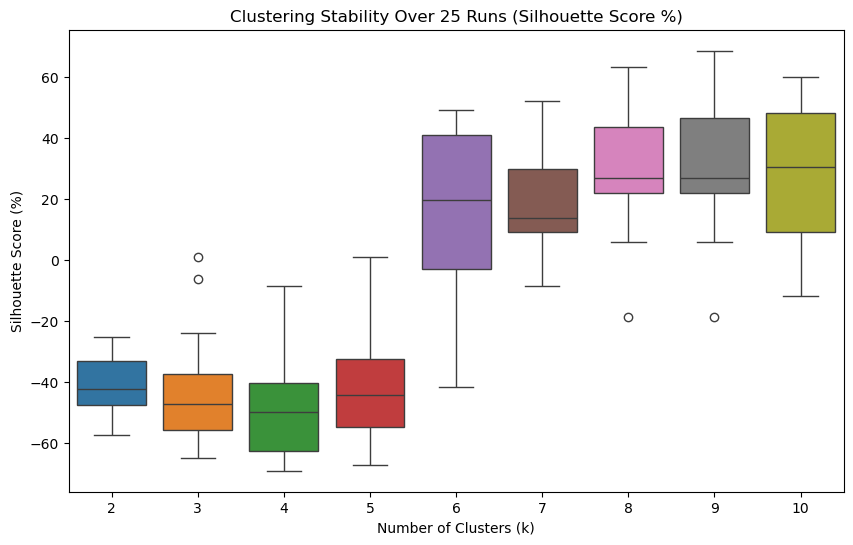

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
import hdbscan
from pyclustering.cluster.kmedoids import kmedoids
import random
import pandas as pd
from sklearn.mixture import GaussianMixture

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load dataset (replace with actual data)
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# Define clustering stability test
num_runs = 25
k_values = range(2, 11)
silhouette_scores = {k: [] for k in k_values}

def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

for k in k_values:
    for _ in range(num_runs):
        # Step 1: HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=max(1, k // 2))
        hdb_labels = clusterer.fit_predict(X)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(hdb_labels[mask]))
        if n_clusters < 2:
            continue
        
        # Step 2: Alternative K-Medoids
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        
        # Step 3: GMM
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        # Compute silhouette score
        try:
            sil_score = silhouette_score(X_filtered, gmm_labels) * 100  # Convert to percentage
        except Exception:
            sil_score = -100
        silhouette_scores[k].append(sil_score)

# Stability box plot (silhouette scores as percentages)
plt.figure(figsize=(10, 6))
sns.boxplot(data=[silhouette_scores[k] for k in k_values])
plt.xticks(ticks=range(len(k_values)), labels=k_values)
plt.title("Clustering Stability Over 25 Runs (Silhouette Score %)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score (%)")
plt.show()


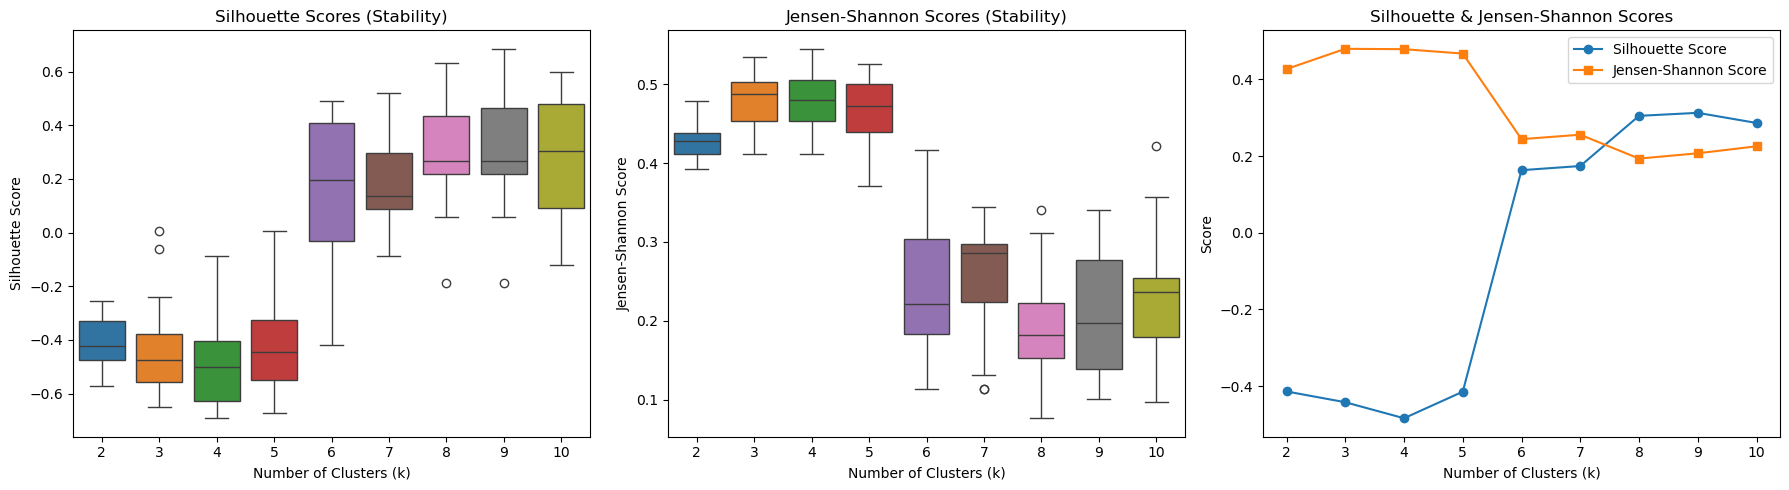

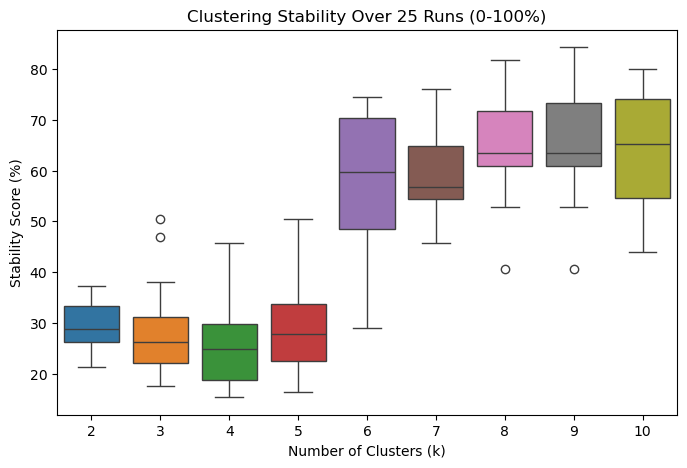

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
import hdbscan
from pyclustering.cluster.kmedoids import kmedoids
import random
import pandas as pd
from sklearn.mixture import GaussianMixture

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load dataset (replace with actual data)
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# Define clustering stability test
num_runs = 25
k_values = range(2, 11)
silhouette_scores = {k: [] for k in k_values}
jensen_shannon_scores = {k: [] for k in k_values}
stability_scores = {k: [] for k in k_values}  # Stability as percentage

def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

for k in k_values:
    for _ in range(num_runs):
        # Step 1: HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=max(1, k // 2))
        hdb_labels = clusterer.fit_predict(X)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(hdb_labels[mask]))
        if n_clusters < 2:
            continue
        
        # Step 2: Alternative K-Medoids
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        
        # Step 3: GMM
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        # Compute silhouette score
        try:
            sil_score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            sil_score = -1
        silhouette_scores[k].append(sil_score)
        
        # Compute Jensen-Shannon score
        cluster_probs = gmm.predict_proba(X_filtered).mean(axis=0)
        uniform_dist = np.ones(n_clusters) / n_clusters
        js_score = jensenshannon(cluster_probs, uniform_dist)
        jensen_shannon_scores[k].append(js_score)
        
        # Compute Stability Score (Normalized Silhouette)
        stability = max(0, min(1, (sil_score + 1) / 2)) * 100  # Convert to 0-100%
        stability_scores[k].append(stability)

# Convert results into boxplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot for silhouette scores
sns.boxplot(data=[silhouette_scores[k] for k in k_values], ax=axs[0])
axs[0].set_xticklabels(k_values)
axs[0].set_title("Silhouette Scores (Stability)")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Silhouette Score")

# Boxplot for Jensen-Shannon scores
sns.boxplot(data=[jensen_shannon_scores[k] for k in k_values], ax=axs[1])
axs[1].set_xticklabels(k_values)
axs[1].set_title("Jensen-Shannon Scores (Stability)")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Jensen-Shannon Score")

# Line plot for silhouette and Jensen-Shannon scores
mean_silhouette = [np.mean(silhouette_scores[k]) for k in k_values]
mean_js = [np.mean(jensen_shannon_scores[k]) for k in k_values]
axs[2].plot(k_values, mean_silhouette, marker='o', label='Silhouette Score')
axs[2].plot(k_values, mean_js, marker='s', label='Jensen-Shannon Score')
axs[2].set_title("Silhouette & Jensen-Shannon Scores")
axs[2].set_xlabel("Number of Clusters (k)")
axs[2].set_ylabel("Score")
axs[2].legend()

plt.tight_layout()
plt.show()

# Separate box plot for stability scores
plt.figure(figsize=(8, 5))
sns.boxplot(data=[stability_scores[k] for k in k_values])
plt.xticks(ticks=range(len(k_values)), labels=k_values)
plt.title("Clustering Stability Over 25 Runs (0-100%)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Stability Score (%)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import random
import hdbscan
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load CSV files
feature_csv =  r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Features for clustering
coordinate_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv" # Coordinates for plotting

df_features = pd.read_csv(feature_csv)
df_coordinates = pd.read_csv(coordinate_csv)

df = df_features.merge(df_coordinates, on="Cell Number", how="inner")
X = df_features.drop(columns=["Cell Number"]).values  # Feature matrix for clustering
coordinates = df_coordinates[["X", "Y"]].values  # Extract coordinates

# Define clustering stability test
num_runs = 25
k_values = range(2, 11)
silhouette_scores = {k: [] for k in k_values}
jensen_shannon_scores = {k: [] for k in k_values}
stability_scores = {k: [] for k in k_values}  # Stability as percentage

# Function to run K-Medoids
def run_alternative_kmedoids(X, n_clusters):
    data_list = X.tolist()
    n_samples = len(data_list)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# Perform clustering for k=2 to k=10
for k in k_values:
    for _ in range(num_runs):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=max(1, k // 2))
        hdb_labels = clusterer.fit_predict(X)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(hdb_labels[mask]))
        if n_clusters < 2:
            continue

        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters)
        
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue

        sil_score = silhouette_score(X_filtered, gmm_labels) if len(set(gmm_labels)) > 1 else -1
        cluster_probs = gmm.predict_proba(X_filtered).mean(axis=0)
        uniform_dist = np.ones(n_clusters) / n_clusters
        js_score = jensenshannon(cluster_probs, uniform_dist)
        stability = max(0, min(1, (sil_score + 1) / 2)) * 100  # Convert to 0-100%
        
        silhouette_scores[k].append(sil_score)
        jensen_shannon_scores[k].append(js_score)
        stability_scores[k].append(stability)

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(data=[silhouette_scores[k] for k in k_values], ax=axs[0])
axs[0].set_xticklabels(k_values)
axs[0].set_title("Silhouette Scores (Stability)")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Silhouette Score")

sns.boxplot(data=[jensen_shannon_scores[k] for k in k_values], ax=axs[1])
axs[1].set_xticklabels(k_values)
axs[1].set_title("Jensen-Shannon Scores (Stability)")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Jensen-Shannon Score")

mean_silhouette = [np.mean(silhouette_scores[k]) for k in k_values]
mean_js = [np.mean(jensen_shannon_scores[k]) for k in k_values]
axs[2].plot(k_values, mean_silhouette, marker='o', label='Silhouette Score')
axs[2].plot(k_values, mean_js, marker='s', label='Jensen-Shannon Score')
axs[2].set_title("Silhouette & Jensen-Shannon Scores")
axs[2].set_xlabel("Number of Clusters (k)")
axs[2].set_ylabel("Score")
axs[2].legend()
plt.show()

# Generate cluster overlay images
image_shape = (512, 512, 3)
base_image = np.ones(image_shape, dtype=np.uint8) * 255

cluster_colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
    (255, 0, 255), (0, 255, 255), (128, 0, 0), (0, 128, 0),
    (0, 0, 128), (128, 128, 0)
]

for k in k_values:
    overlay_image = base_image.copy()
    for i, (x, y) in enumerate(coordinates):
        cluster_idx = gmm_labels[i] if i < len(gmm_labels) else -1
        if cluster_idx != -1:
            color = cluster_colors[cluster_idx % len(cluster_colors)]
            cv2.circle(overlay_image, (int(x), int(y)), 5, color, -1)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Cluster Overlay (k={k})")
    plt.axis("off")
    plt.show()

In [41]:
print(df_coordinates.columns)


Index(['Cell Number', 'Cell Type', 'Area', 'Perimeter', 'Major Axis Length',
       'Minor Axis Length', 'Soma Diameter', 'Aspect Ratio', 'Circularity',
       'Solidity', 'Nucleolus Present', 'X Centroid', 'Y Centroid'],
      dtype='object')


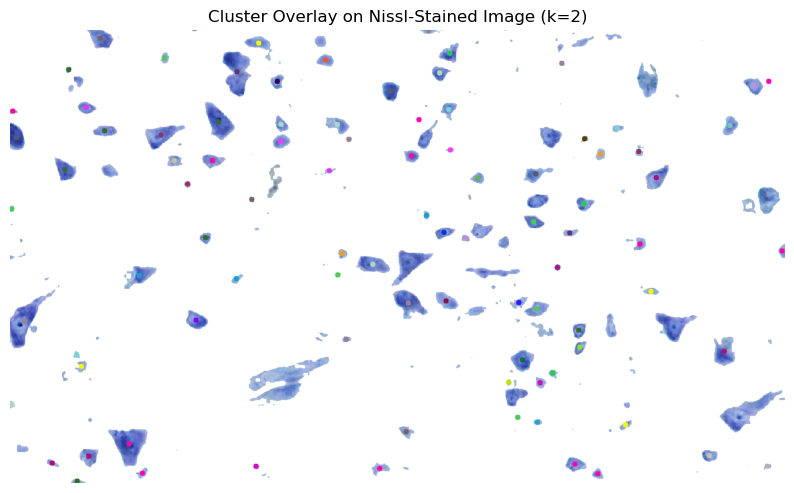

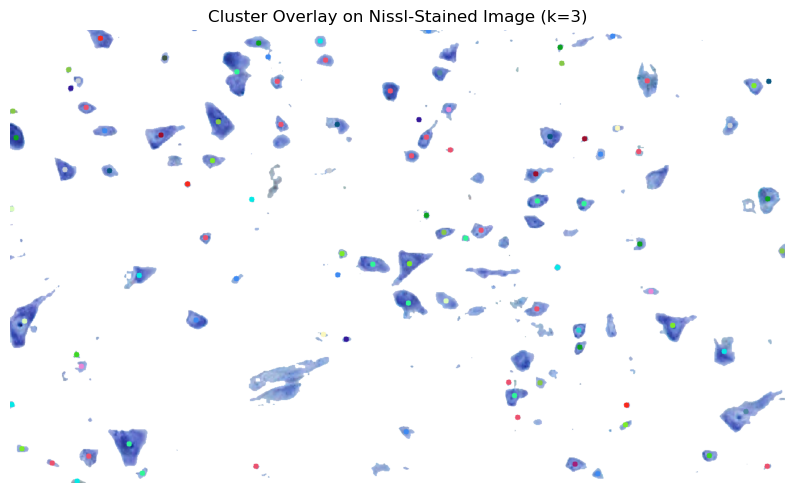

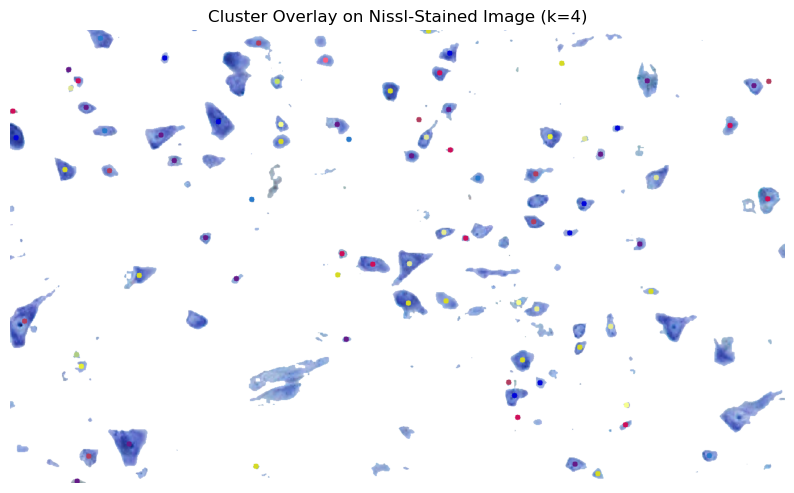

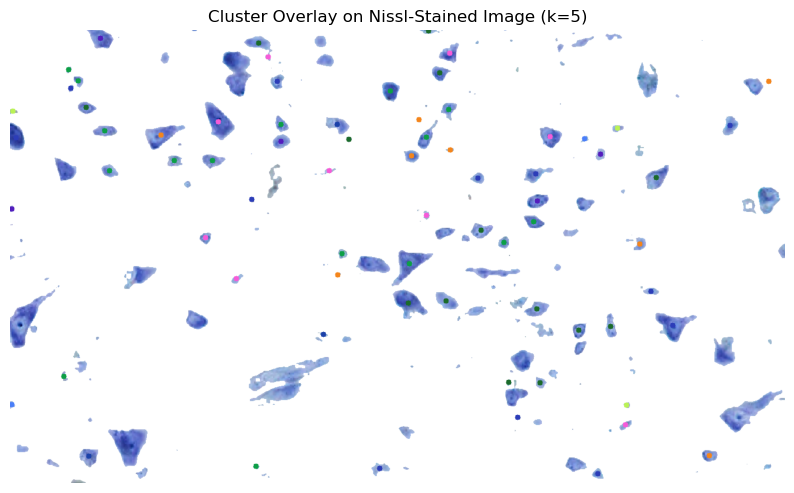

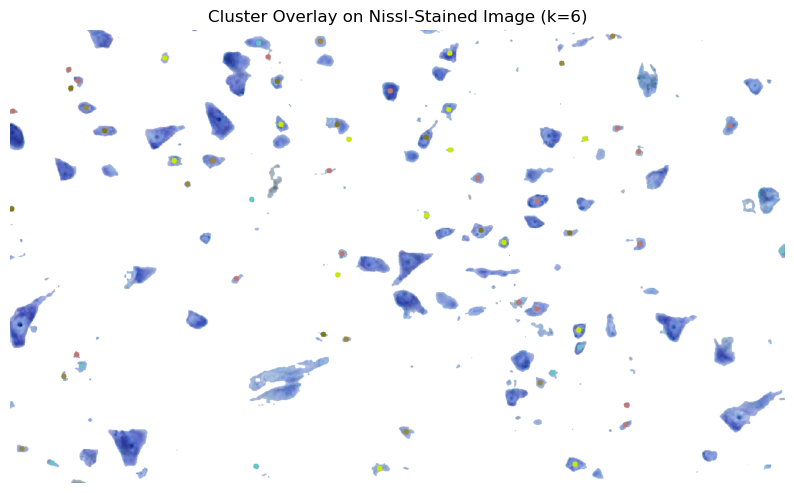

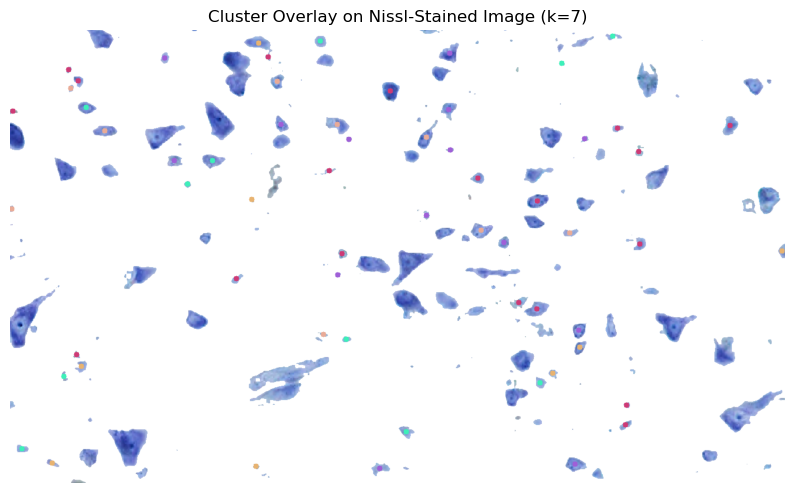

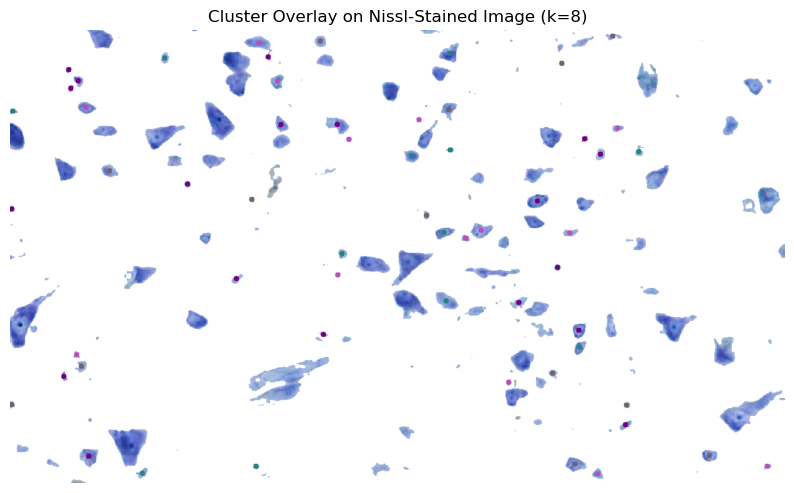

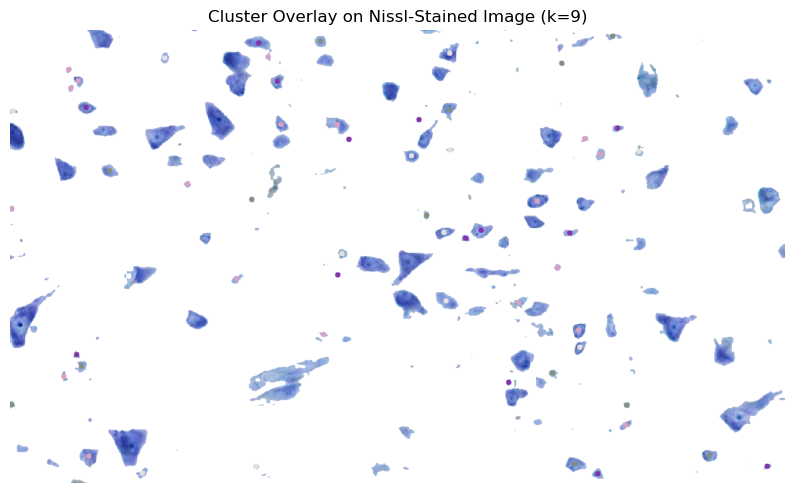

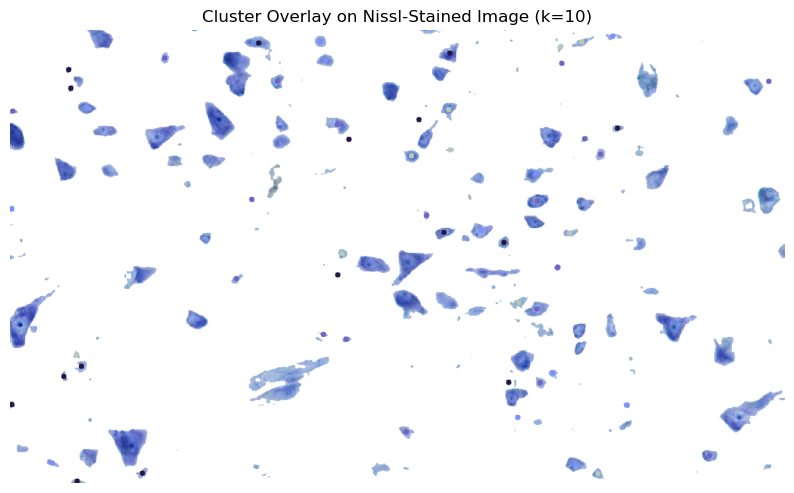

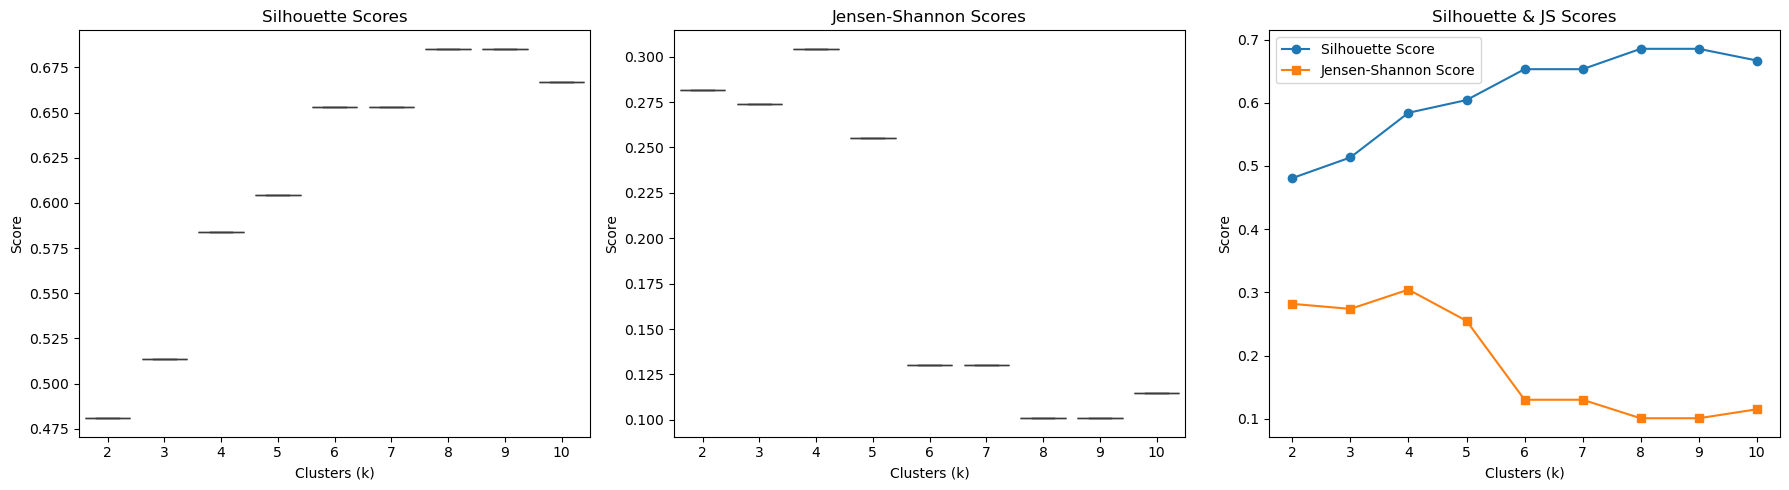

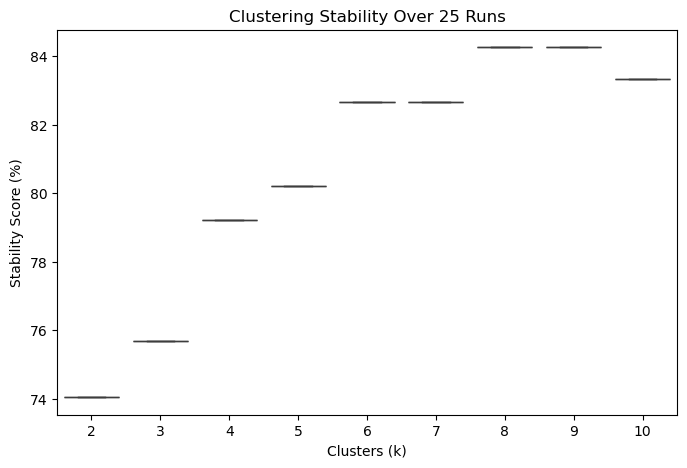

In [49]:
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
import hdbscan
from pyclustering.cluster.kmedoids import kmedoids

# Set random seed
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load datasets
feature_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv" 
coordinate_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"
stained_image_path = "restored_white_background_debug-Copy1.png"  # Upload your image

# Load CSVs
df_features = pd.read_csv(feature_csv)
df_coordinates = pd.read_csv(coordinate_csv)

# Merge on 'Cell Number'
df_merged = df_coordinates.drop(columns=["Nucleolus Present"]).merge(df_features, on="Cell Number", how="inner")
df = df_features.drop(columns=["Cell Number"]).values
coordinates = df_merged[["X Centroid", "Y Centroid"]].values

# Clustering parameters
num_runs = 25
k_values = range(2, 11)
silhouette_scores = {k: [] for k in k_values}
jensen_shannon_scores = {k: [] for k in k_values}
stability_scores = {k: [] for k in k_values}

# Function to run K-Medoids
def run_alternative_kmedoids(X, n_clusters):
    data_list = X.tolist()
    n_samples = len(data_list)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    return labels

# Run clustering
for k in k_values:
    for _ in range(num_runs):
        # HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=max(1, k // 2))
        hdb_labels = clusterer.fit_predict(df)

        # Remove noise points (label -1 in HDBSCAN)
        mask = hdb_labels != -1
        X_filtered = df[mask]
        coordinates_filtered = coordinates[mask]

        # If HDBSCAN finds no meaningful clusters, skip this run
        if len(np.unique(hdb_labels[mask])) < 2:
            continue

        # Apply K-Medoids to the filtered data
        kmed_labels = run_alternative_kmedoids(X_filtered, len(np.unique(hdb_labels[mask])))

        # Apply GMM to the filtered data
        try:
            gmm = GaussianMixture(n_components=len(np.unique(hdb_labels[mask])), random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        # Combine the results
        final_labels = np.full(len(df), -1)
        final_labels[mask] = gmm_labels
        
        # Evaluate metrics
        sil_score = silhouette_score(X_filtered, gmm_labels)
        silhouette_scores[k].append(sil_score)
        
        cluster_probs = gmm.predict_proba(X_filtered).mean(axis=0)
        uniform_dist = np.ones(len(np.unique(gmm_labels))) / len(np.unique(gmm_labels))
        js_score = jensenshannon(cluster_probs, uniform_dist)
        jensen_shannon_scores[k].append(js_score)
        
        stability = max(0, min(1, (sil_score + 1) / 2)) * 100
        stability_scores[k].append(stability)

    # Ensure the number of clusters for this run is exactly k
    final_num_clusters = len(np.unique(final_labels))
    if final_num_clusters != k:
        print(f"Warning: Expected {k} clusters but got {final_num_clusters} clusters for k={k}")

    # Generate overlay images for the current k
    num_clusters = final_num_clusters
    cluster_colors = np.random.randint(0, 255, size=(num_clusters, 3)) / 255.0

    # Overlay clusters on the image
    overlay_image = cv2.imread(stained_image_path)
    overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)
    
    for i, (x, y) in enumerate(coordinates_filtered):
        cluster_idx = final_labels[i] if i < len(final_labels) else -1
        if cluster_idx != -1:
            color = tuple(int(c * 255) for c in cluster_colors[cluster_idx][:3])
            cv2.circle(overlay_image, (int(x), int(y)), 5, color, -1)

    # Show and save the overlay image for the current k
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay_image)
    plt.axis("off")
    plt.title(f"Cluster Overlay on Nissl-Stained Image (k={k})")
    plt.show()

    # Optionally save the overlay images
    overlay_image_path = f"overlay_k{k}.png"
    cv2.imwrite(overlay_image_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))

# Generate evaluation plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=[silhouette_scores[k] for k in k_values], ax=axs[0])
axs[0].set_xticklabels(k_values)
axs[0].set_title("Silhouette Scores")
axs[0].set_xlabel("Clusters (k)")
axs[0].set_ylabel("Score")

sns.boxplot(data=[jensen_shannon_scores[k] for k in k_values], ax=axs[1])
axs[1].set_xticklabels(k_values)
axs[1].set_title("Jensen-Shannon Scores")
axs[1].set_xlabel("Clusters (k)")
axs[1].set_ylabel("Score")

mean_silhouette = [np.mean(silhouette_scores[k]) for k in k_values]
mean_js = [np.mean(jensen_shannon_scores[k]) for k in k_values]
axs[2].plot(k_values, mean_silhouette, marker='o', label='Silhouette Score')
axs[2].plot(k_values, mean_js, marker='s', label='Jensen-Shannon Score')
axs[2].set_title("Silhouette & JS Scores")
axs[2].set_xlabel("Clusters (k)")
axs[2].set_ylabel("Score")
axs[2].legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=[stability_scores[k] for k in k_values])
plt.xticks(ticks=range(len(k_values)), labels=k_values)
plt.title("Clustering Stability Over 25 Runs")
plt.xlabel("Clusters (k)")
plt.ylabel("Stability Score (%)")
plt.show()


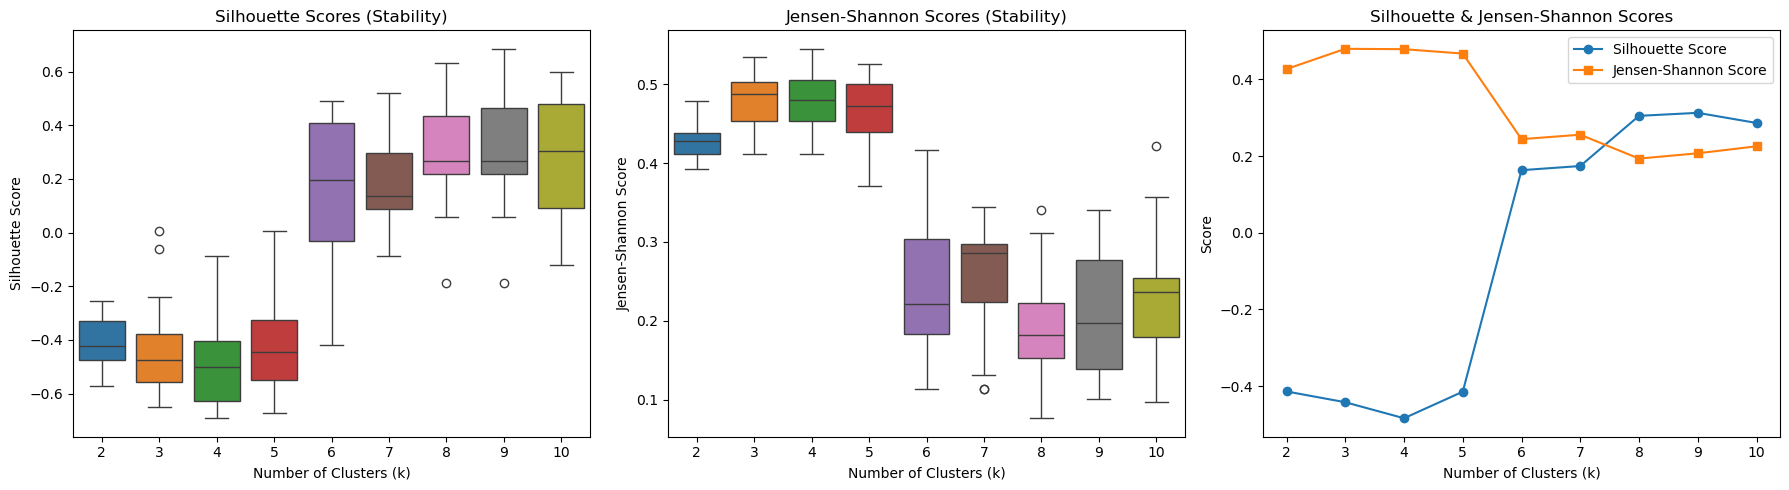

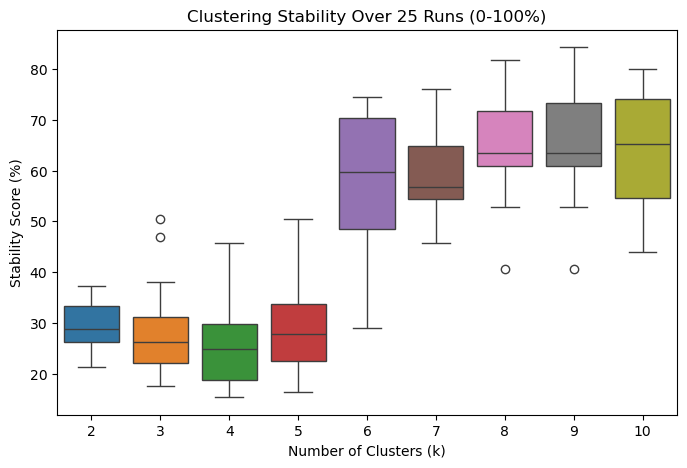

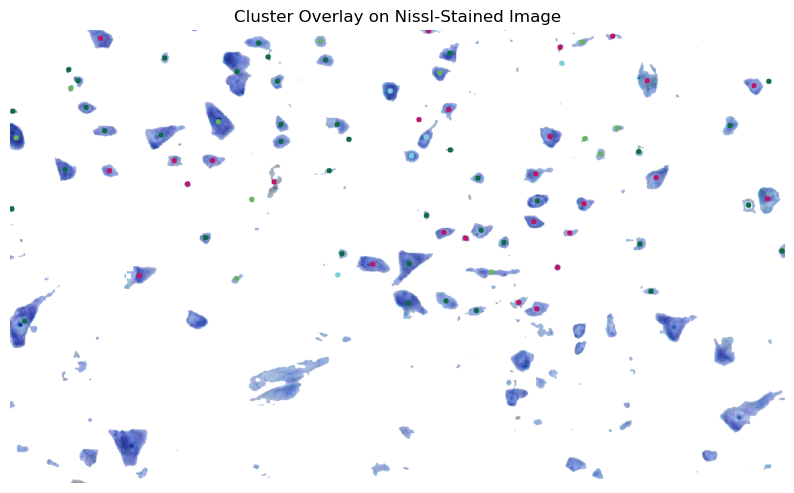

In [58]:
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
import hdbscan
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.mixture import GaussianMixture

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load CSVs
feature_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv" 
coordinate_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"
stained_image_path = "restored_white_background_debug-Copy1.png"  # Upload your image

df_features = pd.read_csv(feature_csv)
df_coordinates = pd.read_csv(coordinate_csv)

# Merge on 'Cell Number'
df_merged = df_coordinates.drop(columns=["Nucleolus Present"]).merge(df_features, on="Cell Number", how="inner")
X = df_features.drop(columns=["Cell Number"]).values
coordinates = df_merged[["X Centroid", "Y Centroid"]].values

# Clustering stability test parameters
num_runs = 25
k_values = range(2, 11)
silhouette_scores = {k: [] for k in k_values}
jensen_shannon_scores = {k: [] for k in k_values}
stability_scores = {k: [] for k in k_values}

def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

for k in k_values:
    for _ in range(num_runs):
        # Step 1: HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=max(1, k // 2))
        hdb_labels = clusterer.fit_predict(X)
        mask = hdb_labels != -1
        if np.sum(mask) < 2:
            continue
        X_filtered = X[mask]
        n_clusters = len(np.unique(hdb_labels[mask]))
        if n_clusters < 2:
            continue
        
        # Step 2: Alternative K-Medoids
        kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
        
        # Step 3: GMM
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X_filtered)
            gmm_labels = gmm.predict(X_filtered)
        except Exception:
            continue
        
        # Compute silhouette score
        try:
            sil_score = silhouette_score(X_filtered, gmm_labels)
        except Exception:
            sil_score = -1
        silhouette_scores[k].append(sil_score)
        
        # Compute Jensen-Shannon score
        cluster_probs = gmm.predict_proba(X_filtered).mean(axis=0)
        uniform_dist = np.ones(n_clusters) / n_clusters
        js_score = jensenshannon(cluster_probs, uniform_dist)
        jensen_shannon_scores[k].append(js_score)
        
        # Compute Stability Score (Normalized Silhouette)
        stability = max(0, min(1, (sil_score + 1) / 2)) * 100  # Convert to 0-100%
        stability_scores[k].append(stability)

# Convert results into boxplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot for silhouette scores
sns.boxplot(data=[silhouette_scores[k] for k in k_values], ax=axs[0])
axs[0].set_xticklabels(k_values)
axs[0].set_title("Silhouette Scores (Stability)")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Silhouette Score")

# Boxplot for Jensen-Shannon scores
sns.boxplot(data=[jensen_shannon_scores[k] for k in k_values], ax=axs[1])
axs[1].set_xticklabels(k_values)
axs[1].set_title("Jensen-Shannon Scores (Stability)")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Jensen-Shannon Score")

# Line plot for silhouette and Jensen-Shannon scores
mean_silhouette = [np.mean(silhouette_scores[k]) for k in k_values]
mean_js = [np.mean(jensen_shannon_scores[k]) for k in k_values]
axs[2].plot(k_values, mean_silhouette, marker='o', label='Silhouette Score')
axs[2].plot(k_values, mean_js, marker='s', label='Jensen-Shannon Score')
axs[2].set_title("Silhouette & Jensen-Shannon Scores")
axs[2].set_xlabel("Number of Clusters (k)")
axs[2].set_ylabel("Score")
axs[2].legend()

plt.tight_layout()
plt.show()

# Separate box plot for stability scores
plt.figure(figsize=(8, 5))
sns.boxplot(data=[stability_scores[k] for k in k_values])
plt.xticks(ticks=range(len(k_values)), labels=k_values)
plt.title("Clustering Stability Over 25 Runs (0-100%)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Stability Score (%)")
plt.show()

# Load stained image
image = cv2.imread(stained_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
overlay_image = image.copy()

# Generate colors for clusters
num_clusters = len(np.unique(gmm_labels))
cluster_colors = np.random.randint(0, 255, size=(num_clusters, 3)) / 255.0

# Overlay clusters
for i, (x, y) in enumerate(coordinates):
    cluster_idx = gmm_labels[i] if i < len(gmm_labels) else -1
    if cluster_idx != -1:
        color = tuple(int(c * 255) for c in cluster_colors[cluster_idx][:3])
        cv2.circle(overlay_image, (int(x), int(y)), 5, color, -1)

# Show overlay
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.axis("off")
plt.title("Cluster Overlay on Nissl-Stained Image")
plt.show()


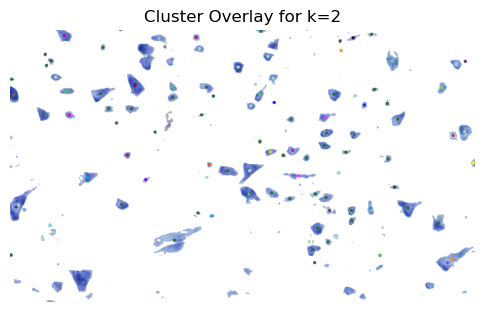

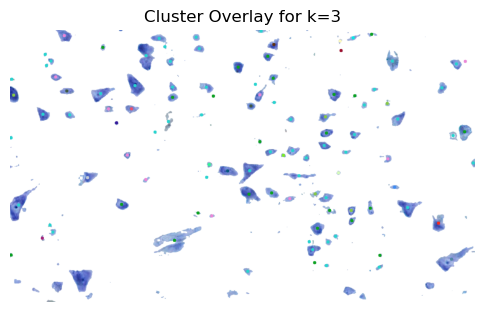

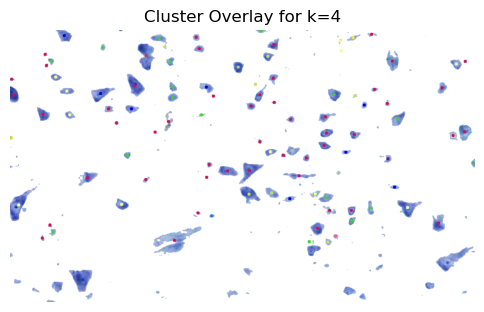

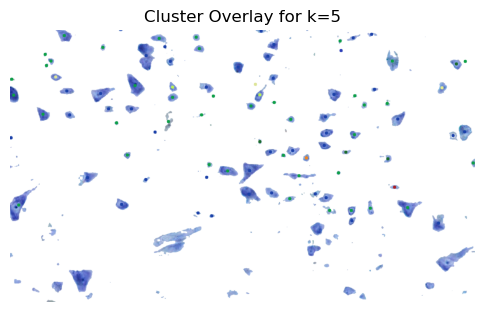

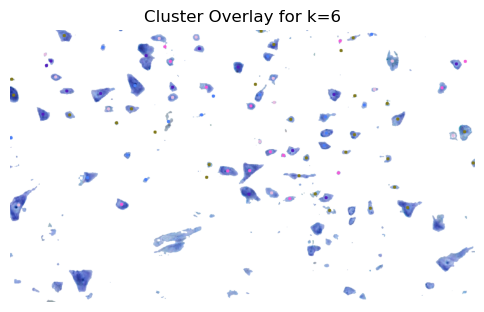

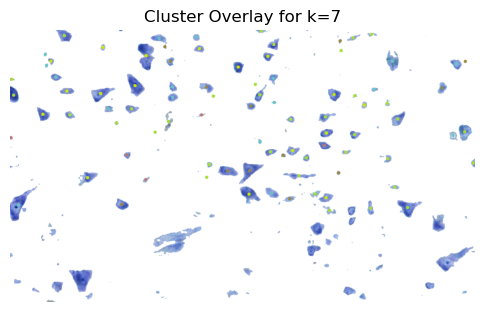

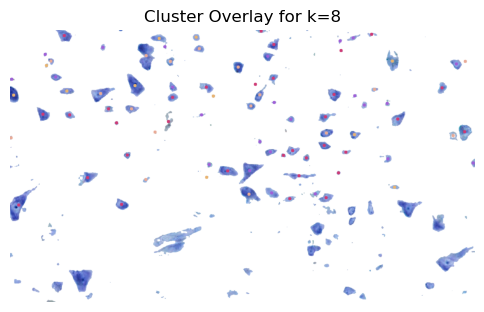

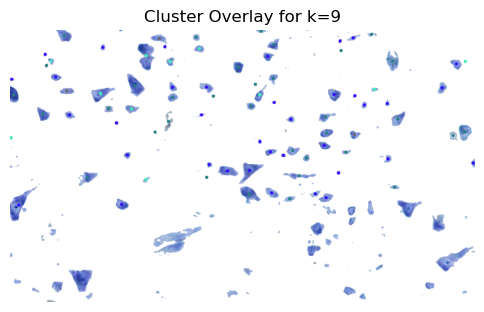

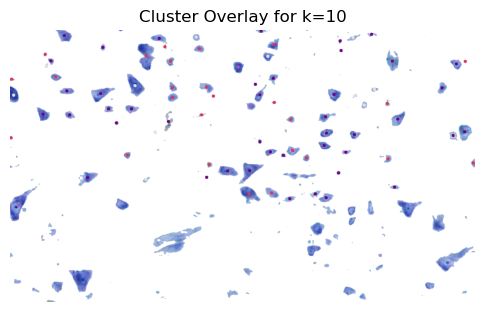

In [69]:
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
import hdbscan
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.mixture import GaussianMixture
import os

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load CSVs
feature_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv" 
coordinate_csv = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\moved_files\data_cell_with_centroids.csv"
stained_image_path = "restored_white_background_debug-Copy1.png"  # Upload your image

df_features = pd.read_csv(feature_csv)
df_coordinates = pd.read_csv(coordinate_csv)

# Merge on 'Cell Number'
df_merged = df_coordinates.drop(columns=["Nucleolus Present"]).merge(df_features, on="Cell Number", how="inner")
X = df_features.drop(columns=["Cell Number"]).values
coordinates = df_merged[["X Centroid", "Y Centroid"]].values

# Clustering stability test parameters
k_values = range(2, 11)

# Helper function for K-Medoids
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# Load stained image
image = cv2.imread(stained_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create folder to save images
output_dir = "cluster_overlays"
os.makedirs(output_dir, exist_ok=True)

# Loop over k_values (2 to 10)
for k in k_values:
    # HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=k, min_samples=max(1, k // 2))
    hdb_labels = clusterer.fit_predict(X)
    mask = hdb_labels != -1
    if np.sum(mask) < 2:
        continue
    X_filtered = X[mask]
    n_clusters = len(np.unique(hdb_labels[mask]))
    if n_clusters < 2:
        continue
    
    # Alternative K-Medoids
    kmed_labels, medoid_coords = run_alternative_kmedoids(X_filtered, n_clusters, random_state)
    
    # GMM clustering
    try:
        gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
        gmm.fit(X_filtered)
        gmm_labels = gmm.predict(X_filtered)
    except Exception:
        continue
    
    # Generate cluster colors
    cluster_colors = np.random.randint(0, 255, size=(n_clusters, 3)) / 255.0

    # Overlay clusters on the image
    overlay_image = image.copy()

    for i, (x, y) in enumerate(coordinates):
        cluster_idx = gmm_labels[i] if i < len(gmm_labels) else -1
        if cluster_idx != -1:
            color = tuple(int(c * 255) for c in cluster_colors[cluster_idx][:3])
            cv2.circle(overlay_image, (int(x), int(y)), 5, color, -1)

    # Save the overlay image for the current k
    overlay_filename = os.path.join(output_dir, f"cluster_overlay_k{str(k)}.png")
    cv2.imwrite(overlay_filename, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))

# Display saved images for k=2 to k=10
for k in k_values:
    overlay_filename = os.path.join(output_dir, f"cluster_overlay_k{str(k)}.png")
    img = cv2.imread(overlay_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Cluster Overlay for k={k}")
    plt.show()
